In [2]:
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio, IterativeStratifiedSplitter
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
from collections import Counter

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\__init__.py)


In [3]:
# Odor Labels
TASKS = [
    'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
    'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
    'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
    'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
    'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
    'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
    'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
    'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
    'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
    'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
    'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
    'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
    'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
    'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
    'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
    'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
    'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
    'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
    'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
    'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]
len(TASKS)

138

In [4]:
input_file = '../../data/curated dataset/curated_GS_LF_merged_4983.csv'
featurizer = GraphFeaturizer()
smiles_field = 'nonStereoSMILES' # column that contains SMILES

In [5]:
loader = dc.data.CSVLoader(tasks=TASKS,
feature_field=smiles_field,
featurizer=featurizer)

In [6]:
dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)
randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
train_dataset, test_dataset, valid_dataset = randomstratifiedsplitter.train_valid_test_split(dataset, frac_train = 0.8, frac_valid = 0.1, frac_test = 0.1, seed = 1)
train_ratios = get_class_imbalance_ratio(train_dataset)


In [7]:
assert len(train_ratios) == n_tasks

In [8]:
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*20, staircase=True)

In [9]:
model = MPNNPOMModel(n_tasks = n_tasks,
                     batch_size = 128,
                     learning_rate = learning_rate,
                     class_imbalance_ratio = train_ratios,
                     loss_aggr_type = 'sum',
                     node_out_feats = 100,
                     edge_hidden_feats = 75,
                     edge_out_feats = 100,
                     num_step_message_passing = 5,
                     mpnn_residual = True,
                     message_aggregator_type = 'sum',
                     mode = 'classification',
                     number_atom_features = GraphConvConstants.ATOM_FDIM,
                     number_bond_features = GraphConvConstants.BOND_FDIM,
                     n_classes = 1,
                     readout_type = 'set2set',
                     num_step_set2set = 3,
                     num_layer_set2set = 2,
                     ffn_hidden_list = [392, 392],
                     ffn_embeddings = 256,
                     ffn_activation = 'relu',
                     ffn_dropout_p = 0.12,
                     ffn_dropout_at_input_no_act = False,
                     weight_decay = 1e-5,
                     self_loop = False,
                     optimizer_name = 'adam',
                     log_frequency = 32,
                     model_dir = './experiments',
                     device_name ='cpu')

In [10]:

import torch
checkpoint = torch.load('checkpoint.pt', map_location=torch.device('cpu'))
if 'model_state_dict' in checkpoint:
    model.model.load_state_dict(checkpoint['model_state_dict'], strict=False)
else:
    model.model.load_state_dict(checkpoint, strict=False)
model.model.eval()  


C:\Users\sarab\AppData\Local\Temp\ipykernel_10236\2995347586.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pt', map_location=torch.

MPNNPOM(
  (mpnn): CustomMPNNGNN(
    (project_node_feats): Sequential(
      (0): Linear(in_features=134, out_features=100, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=6, out_features=75, bias=True)
        (1): ReLU()
        (2): Linear(in_features=75, out_features=10000, bias=True)
      )
      (res_fc): Identity()
    )
    (gru): GRU(100, 100)
  )
  (project_edge_feats): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): ReLU()
  )
  (readout_set2set): Set2Set(
    n_iters=3
    (lstm): LSTM(400, 200, num_layers=2)
  )
  (ffn): CustomPositionwiseFeedForward(
    (activation): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=400, out_features=392, bias=True)
      (1): Linear(in_features=392, out_features=392, bias=True)
      (2): Linear(in_features=392, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=138, bias=True)
    )
    (

In [11]:

csv_file_path = '../../data/GAE/logistic equation/novel_odorrous_set_log_eq.csv'
df = pd.read_csv(csv_file_path)

In [12]:
smiles_list = df['SMILE'].tolist()
print(smiles_list)


featurizer = GraphFeaturizer()
featurized_data = featurizer.featurize(smiles_list)

# Processing each featurized data point and collect top 10 odors
all_top_odors = []
problematic_smiles = []

for i, featurized_mol in enumerate(featurized_data):
    try:
        
        single_mol_dataset = dc.data.NumpyDataset([featurized_mol])

        
        prediction = model.predict(single_mol_dataset)

        
        odor_probs = prediction.squeeze()
        high_prob_indices = np.where(odor_probs > 0.5)[0]
        
        
        sorted_indices = high_prob_indices[np.argsort(odor_probs[high_prob_indices])[::-1]]
        
        
        top_odors = [TASKS[i] for i in sorted_indices]
        all_top_odors.extend(top_odors)

        # Printing top odors for each molecule
        print(f"\nTop odors for {smiles_list[i]} (probability > 0.5):")
        for odor, score in zip(top_odors, odor_probs[sorted_indices]):
            print(f"{odor}: {score:.4f}")

    except KeyError as e:
        print(f"\nError processing SMILES: {smiles_list[i]}")
        print(f"Error message: {str(e)}")
        problematic_smiles.append(smiles_list[i])
        continue

['CCCOCC', 'COCCO', 'CSS1=C(C)COC1', 'NCS', 'C=CC(S)CNCCCC', 'CCCCCCCC=CSO', 'CCCOOC(C)OC', 'CCSSCO', 'CCOCCOC', 'COCCCO', 'CCCOC[NH-]', 'CCCC(C)=S', 'CCS1=CCC(O)C=C1', 'CCC(=O)C=O', 'C=CCC=CCC', 'CC1C=CN=CC1', 'C=C(CCCSCCCCC)OC(C)CCC', 'Cc1occc1CS', 'NCCCCO', 'C=C1CCCC(CO)O1', 'C=C(C)C(C)C(C)=O', 'CSC=C(C)C', 'C1CC1', 'C=C(SC)C1C=COCC1', 'CC(C)OC=N', 'C=CC(C)CC', 'OCS1=CCC=CO1', 'CCCCCSC(=O)CC', 'CC1CCCC1=S', 'CC', 'CC=CC(C)S', 'C=C(C)C(C)OC', 'CCOCC(=O)O', 'CCCCCSC', 'C=C(C)C', 'C1CSCCN1', 'CC(CCO)CCCSO', 'CCOC(=S)CC(O)CC', 'C=C(O)CCC', 'CCCCCCC(C)SCC', 'COC(C)(C)O', 'CCC(=O)C1=CCC(OC)=CC1', 'CC1CCOC1', 'CC=NSCS', 'CCC=C(C)C(=O)SC', 'C=CCOCC=CC', 'CC(=O)CCC(O)SCCO', 'C=C(O)CCOCC', 'CC(=O)OCC1C=CC2=C(C1)OCC2', 'CCCCC', 'CCOCC(C)O', 'C=C(CCC)C(O)CC', 'OCC=CCO', 'O=C(O)O', 'OSCS', 'C=CCCCC=O', 'CC1=CC=CC1', 'CC(O)S', 'NCCCC(=O)S', 'CCC(CC)CCCS', 'C=C1CC2CCC1C2(C)S', 'CCC(O)CC1=CCC=CS1', 'CCCCCC1OCCC1O', 'CCC=CC(C)OCS', 'CCC(O)SC', 'CSCSCSS', 'CCCC=CCC(=N)O', 'OS1=NC(OS)C(S)C=C1', 'C1CO1

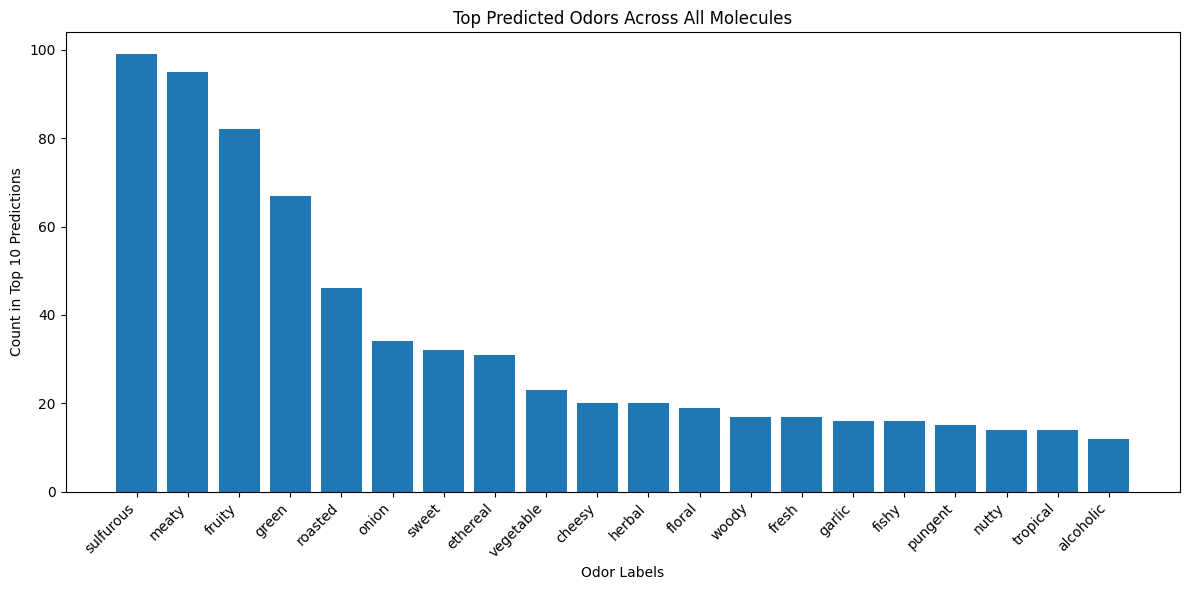


Counts of odors in top 10 predictions across all molecules:
sulfurous: 99
meaty: 95
fruity: 82
green: 67
roasted: 46
onion: 34
sweet: 32
ethereal: 31
vegetable: 23
cheesy: 20
herbal: 20
floral: 19
woody: 17
fresh: 17
garlic: 16
fishy: 16
pungent: 15
nutty: 14
tropical: 14
alcoholic: 12
savory: 12
odorless: 11
fatty: 11
citrus: 11
alliaceous: 10
grapefruit: 9
fermented: 8
mint: 7
sharp: 7
solvent: 6
gassy: 5
musty: 5
earthy: 5
caramellic: 4
burnt: 4
musk: 4
camphoreous: 4
winey: 4
apple: 3
animal: 3
amber: 3
waxy: 3
cognac: 3
cocoa: 3
almond: 3
coffee: 2
dry: 2
popcorn: 2
aldehydic: 2
cabbage: 2
cooling: 2
phenolic: 2
balsamic: 2
vanilla: 2
rose: 2
cooked: 1
buttery: 1
creamy: 1
pine: 1
oily: 1
orange: 1
mushroom: 1
jasmin: 1
hazelnut: 1
chocolate: 1
potato: 1
banana: 1
radish: 1

Problematic SMILES that caused errors:


In [13]:
import os 

odor_counts = Counter(all_top_odors)


plt.figure(figsize=(12, 6))
odors, counts = zip(*odor_counts.most_common(20)) 
plt.bar(odors, counts)
plt.title("Top Predicted Odors Across All Molecules")
plt.xlabel("Odor Labels")
plt.ylabel("Count in Top 10 Predictions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
output_folder = '../../figures/GAE/Top ten odor/'  
os.makedirs(output_folder, exist_ok=True)  
dpi_values = [300, 600, 1200]  
for dpi in dpi_values:
    plt.savefig(f"{output_folder}top_ten_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
plt.show()

# Print the counts for all odors
print("\nCounts of odors in top 10 predictions across all molecules:")
for odor, count in odor_counts.most_common():
    print(f"{odor}: {count}")

# Print the list of problematic SMILES
print("\nProblematic SMILES that caused errors:")
for smiles in problematic_smiles:
    print(smiles)

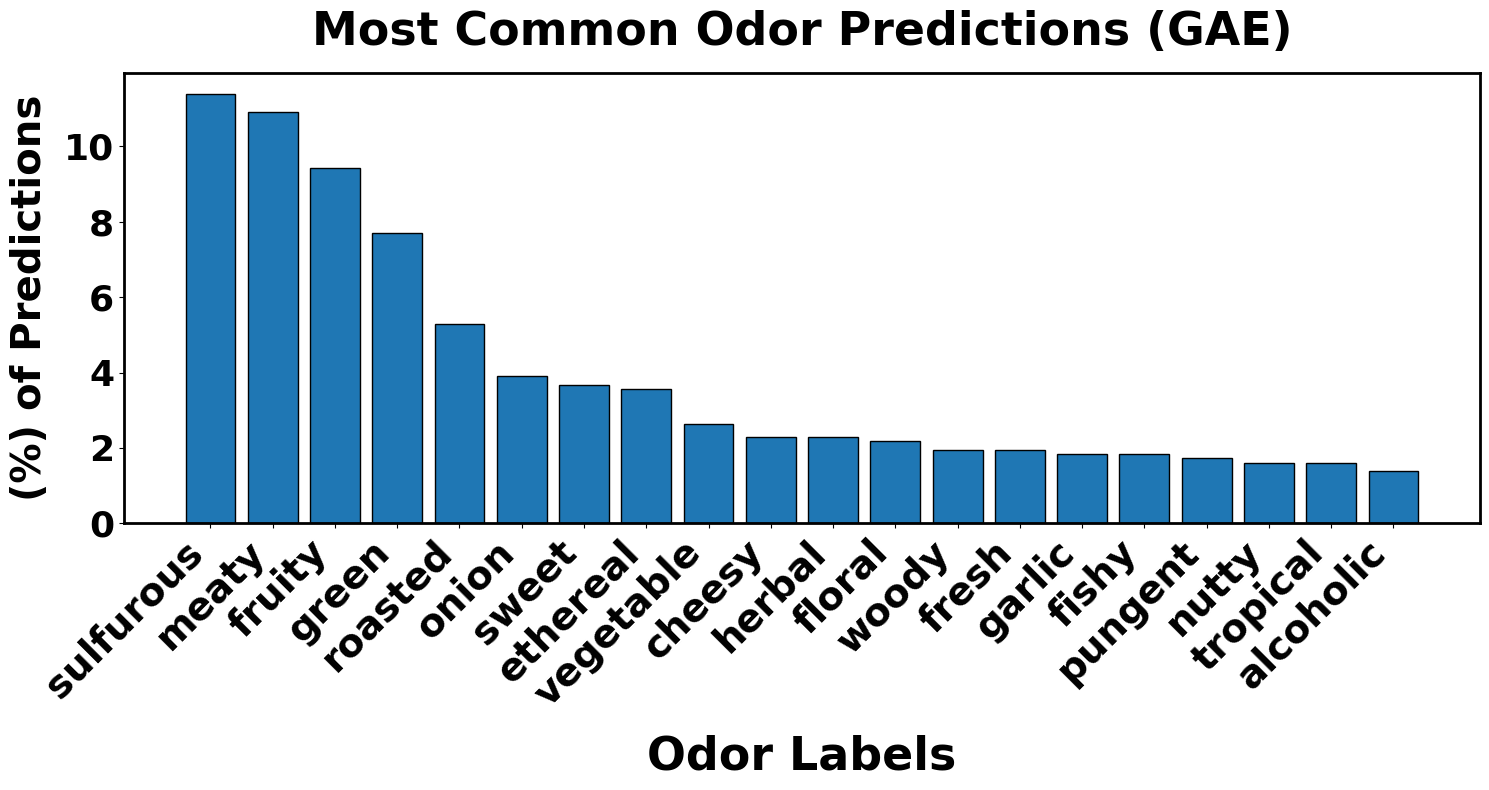


Percentages of top 20 odors in top 10 predictions across all molecules:
sulfurous: 11.38%
meaty: 10.92%
fruity: 9.43%
green: 7.70%
roasted: 5.29%
onion: 3.91%
sweet: 3.68%
ethereal: 3.56%
vegetable: 2.64%
cheesy: 2.30%
herbal: 2.30%
floral: 2.18%
woody: 1.95%
fresh: 1.95%
garlic: 1.84%
fishy: 1.84%
pungent: 1.72%
nutty: 1.61%
tropical: 1.61%
alcoholic: 1.38%

Problematic SMILES that caused errors:


In [14]:
import os
from collections import Counter
import matplotlib.pyplot as plt


odor_counts = Counter(all_top_odors)
total_predictions = sum(odor_counts.values())  


percentages = [(count / total_predictions) * 100 for count in odor_counts.values()]


sorted_odors_percentages = sorted(zip(odor_counts.keys(), percentages), key=lambda x: x[1], reverse=True)


top_20_odors_percentages = sorted_odors_percentages[:20]
top_20_odors, top_20_percentages = zip(*top_20_odors_percentages)


plt.figure(figsize=(15, 8))  


bars = plt.bar(top_20_odors, top_20_percentages, edgecolor='black')
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_edgecolor('black')  
    spine.set_linewidth(2)  

plt.title("Most Common Odor Predictions (GAE)", fontsize=33, fontweight='bold', pad=20)
plt.xlabel("Odor Labels", fontsize=33, fontweight='bold', labelpad=15)
plt.ylabel("(%) of Predictions", fontsize=29, fontweight='bold', labelpad=10)


plt.xticks(rotation=45, ha='right', fontsize=28, fontweight='bold')
plt.yticks(fontsize=26, fontweight='bold')


plt.tight_layout()


output_folder = '../../figures/GAE/Top ten odor/'  
os.makedirs(output_folder, exist_ok=True)  
dpi_values = [300]  
for dpi in dpi_values:
    plt.savefig(f"{output_folder}top_odor_per.png", dpi=dpi, bbox_inches='tight')

#Show the plot
plt.show()

# Printing the percentages for the top 20 odors in descending order
print("\nPercentages of top 20 odors in top 10 predictions across all molecules:")
for odor, percentage in zip(top_20_odors, top_20_percentages):
    print(f"{odor}: {percentage:.2f}%")

# Printing the list of problematic SMILES
print("\nProblematic SMILES that caused errors:")
for smiles in problematic_smiles:
    print(smiles)
